<a href="https://colab.research.google.com/github/gywlsdms123/Report/blob/master/keras_gan_mnist_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Define channel order, module

In [0]:
import argparse

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras import backend as K


K.set_image_data_format('channels_first')

## Define Dataset

In [0]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, batch_size, z_input_dim):
        # load mnist dataset
        # 이미지는 보통 -1~1 사이의 값으로 normalization : generator의 outputlayer를 tanh로
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        self.x_data = ((X_train.astype(np.float32) - 127.5) / 127.5)
        self.x_data = self.x_data.reshape((self.x_data.shape[0], 1) + self.x_data.shape[1:])
        self.batch_size = batch_size
        self.z_input_dim = z_input_dim

    def get_real_sample(self):
        """
        get real sample mnist images

        :return: batch_size number of mnist image data
        """
        return self.x_data[np.random.randint(0, self.x_data.shape[0], size=self.batch_size)]

    def get_z_sample(self, sample_size):
        """
        get z sample data

        :return: random z data (batch_size, z_input_dim) size
        """
        return np.random.uniform(-1.0, 1.0, (sample_size, self.z_input_dim))

- Mnist data test

In [0]:
data = Data(batch_size=2, z_input_dim=10)
print(data.get_real_sample())
print(data.get_z_sample(2))

11493376/11490434 [==============================] - 4s 0us/step
[[[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]


 [[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]]
[[-0.11963706  0.11215759 -0.02771058  0.98094655  0.6094285  -0.53693876
   0.58323735  0.3928728   0.89223964 -0.8962268 ]
 [-0.43915777  0.54376714  0.09353369  0.05417425 -0.68804689  0.12580099
  -0.16996758  0.80601339  0.38318294 -0.93701577]]


## GAN 모델 정의

- discriminator : CNN 판별기로 모델링
- generator : input Z를 확장한 뒤 CNN 생성기로 모델링

In [0]:
class GAN:
    def __init__(self, learning_rate, z_input_dim):
        """
        init params

        :param learning_rate: learning rate of optimizer
        :param z_input_dim: input dim of z
        """
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.combined()

    def discriminator(self):
        """
        define discriminator
        """
        D = Sequential()
        D.add(Conv2D(256, (5, 5),
                     padding='same',
                     input_shape=(1, 28, 28),
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Conv2D(512, (5, 5), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Flatten())
        D.add(Dense(256))
        D.add(LeakyReLU(0.2))
        D.add(Dropout(0.3))
        D.add(Dense(1, activation='sigmoid'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return D

    def generator(self):
        """
        define generator
        """
        G = Sequential()
        G.add(Dense(512, input_dim=self.z_input_dim))
        G.add(LeakyReLU(0.2))
        G.add(Dense(128 * 7 * 7))
        G.add(LeakyReLU(0.2))
        G.add(BatchNormalization())
        G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return G

    def combined(self):
        """
        defien combined gan model
        """
        G, D = self.G, self.D
        D.trainable = False
        GD = Sequential()
        GD.add(G)
        GD.add(D)

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        GD.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        D.trainable = True
        return GD


## Learner 구성

- discriminator와 generator를 다른 epoch 비율로 학습 가능하도록 구성
- 20 epoch 마다 이미지 생성
- D, G를 각각 학습
- 학습 완료 후 loss graph 생성

In [0]:
class Model:
    def __init__(self, batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.data = Data(self.batch_size, self.z_input_dim)

        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D
        self.n_iter_G = n_iter_G
        self.gan = GAN(self.learning_rate, self.z_input_dim)

        # print status
        batch_count = self.data.x_data.shape[0] / self.batch_size
        print('Epochs:', self.epochs)
        print('Batch size:', self.batch_size)
        print('Batches per epoch:', batch_count)
        print('Learning rate:', self.learning_rate)
        print('Image data format:', K.image_data_format())

    def fit(self):
        self.d_loss = []
        self.g_loss = []
        for epoch in range(self.epochs):

            # train discriminator by real data
            dloss = 0
            for iter in range(self.n_iter_D):
                dloss = self.train_D()

            # train GD by generated fake data
            gloss = 0
            for iter in range(self.n_iter_G):
                gloss = self.train_G()

            # save loss data
            self.d_loss.append(dloss)
            self.g_loss.append(gloss)

            # plot and save model each 20n epoch
            if epoch % 20 == 0:
                self.plot_generate_images(epoch, self.gan.G, examples=8)
                print('Epoch:', str(epoch))
                print('Discriminator loss:', str(dloss))
                print('Generator loss:', str(gloss))
        
        # show loss after train
        self.plot_loss_graph(self.g_loss, self.d_loss)

    def train_D(self):
        """
        train Discriminator
        """

        # Real data
        real = self.data.get_real_sample()

        # Generated data
        z = self.data.get_z_sample(self.batch_size)
        generated_images = self.gan.G.predict(z)

        # labeling and concat generated, real images
        x = np.concatenate((real, generated_images), axis=0)
        y = [0.9] * self.batch_size + [0] * self.batch_size

        # train discriminator
        self.gan.D.trainable = True
        loss = self.gan.D.train_on_batch(x, y)
        return loss

    def train_G(self):
        """
        train Generator
        """

        # Generated data
        z = self.data.get_z_sample(self.batch_size)

        # labeling
        y = [1] * self.batch_size

        # train generator
        self.gan.D.trainable = False
        loss = self.gan.GD.train_on_batch(z, y)
        return loss

    def plot_loss_graph(self, g_loss, d_loss):
        """
        Save training loss graph
        """

        # show loss graph
        plt.figure(figsize=(10, 8))
        plt.plot(d_loss, label='Discriminator loss')
        plt.plot(g_loss, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_generate_images(self, epoch, generator, examples=8):
        """
        Save generated mnist images
        """
        # plt info
        dim = (10, 10)
        figsize = (10, 10)

        # generate images
        z = self.data.get_z_sample(examples)
        generated_images = generator.predict(z)

        # show images
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i].reshape((28, 28)), interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()


## 학습 진행

Epochs: 1000
Batch size: 128
Batches per epoch: 468.75
Learning rate: 0.0002
Image data format: channels_first
(8, 1, 28, 28)


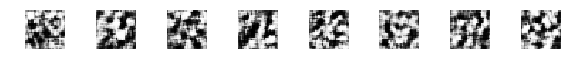

Epoch: 0
Discriminator loss: [0.6824783, 0.08203125]
Generator loss: [0.051154472, 1.0]
(8, 1, 28, 28)


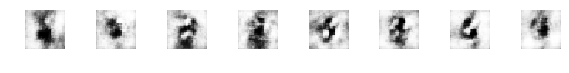

Epoch: 20
Discriminator loss: [0.64817095, 0.14453125]
Generator loss: [1.0227102, 0.2109375]
(8, 1, 28, 28)


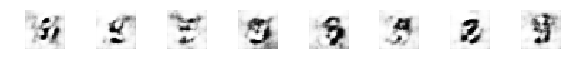

Epoch: 40
Discriminator loss: [0.6238575, 0.4375]
Generator loss: [0.736747, 0.359375]
(8, 1, 28, 28)


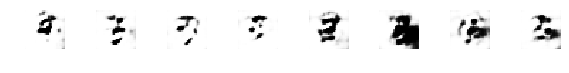

Epoch: 60
Discriminator loss: [0.4873793, 0.40234375]
Generator loss: [0.60958844, 0.8203125]
(8, 1, 28, 28)


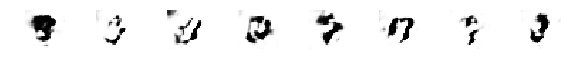

Epoch: 80
Discriminator loss: [0.59304935, 0.42578125]
Generator loss: [0.9950809, 0.046875]
(8, 1, 28, 28)


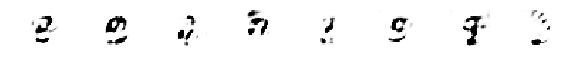

Epoch: 100
Discriminator loss: [0.6271883, 0.328125]
Generator loss: [0.499735, 0.96875]
(8, 1, 28, 28)


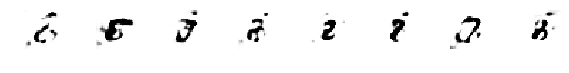

Epoch: 120
Discriminator loss: [0.5636357, 0.4453125]
Generator loss: [1.1480749, 0.0234375]
(8, 1, 28, 28)


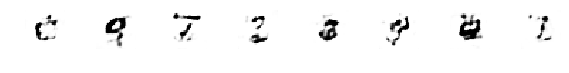

Epoch: 140
Discriminator loss: [0.59532607, 0.28125]
Generator loss: [1.0882254, 0.046875]
(8, 1, 28, 28)


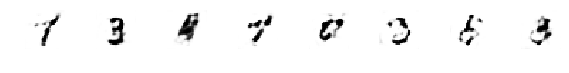

Epoch: 160
Discriminator loss: [0.5874219, 0.4375]
Generator loss: [1.0674753, 0.0390625]
(8, 1, 28, 28)


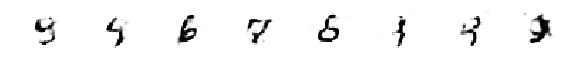

Epoch: 180
Discriminator loss: [0.5764362, 0.44921875]
Generator loss: [0.8085896, 0.296875]
(8, 1, 28, 28)


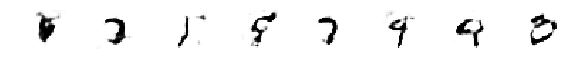

Epoch: 200
Discriminator loss: [0.5863919, 0.4609375]
Generator loss: [0.9914329, 0.1484375]
(8, 1, 28, 28)


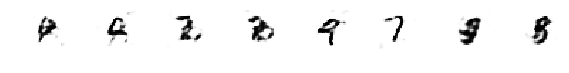

Epoch: 220
Discriminator loss: [0.6250835, 0.4453125]
Generator loss: [1.0009384, 0.125]
(8, 1, 28, 28)


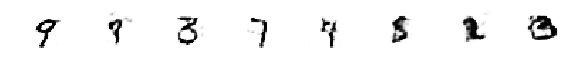

Epoch: 240
Discriminator loss: [0.64763796, 0.46484375]
Generator loss: [0.7211809, 0.4765625]
(8, 1, 28, 28)


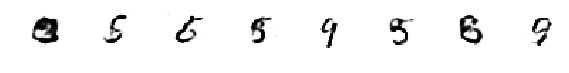

Epoch: 260
Discriminator loss: [0.61026925, 0.44921875]
Generator loss: [0.8641057, 0.234375]
(8, 1, 28, 28)


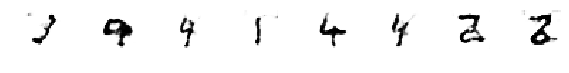

Epoch: 280
Discriminator loss: [0.59909356, 0.34765625]
Generator loss: [1.1635678, 0.0546875]
(8, 1, 28, 28)


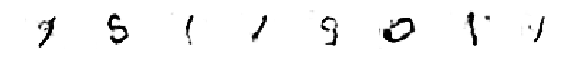

Epoch: 300
Discriminator loss: [0.6840368, 0.14453125]
Generator loss: [1.462673, 0.03125]
(8, 1, 28, 28)


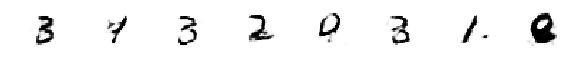

Epoch: 320
Discriminator loss: [0.62663114, 0.32421875]
Generator loss: [1.2705662, 0.0]
(8, 1, 28, 28)


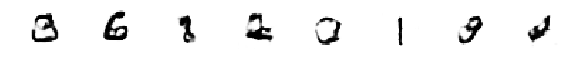

Epoch: 340
Discriminator loss: [0.58800584, 0.47265625]
Generator loss: [0.9641826, 0.1015625]
(8, 1, 28, 28)


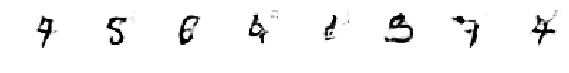

Epoch: 360
Discriminator loss: [0.653413, 0.3046875]
Generator loss: [1.0663514, 0.1171875]
(8, 1, 28, 28)


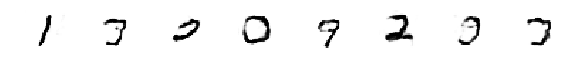

Epoch: 380
Discriminator loss: [0.6408118, 0.46875]
Generator loss: [0.7108668, 0.46875]
(8, 1, 28, 28)


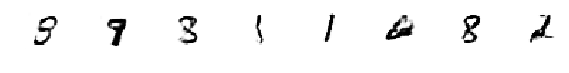

Epoch: 400
Discriminator loss: [0.683139, 0.296875]
Generator loss: [1.333329, 0.0078125]
(8, 1, 28, 28)


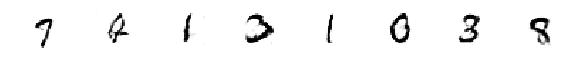

Epoch: 420
Discriminator loss: [0.61350703, 0.4609375]
Generator loss: [0.9144013, 0.15625]
(8, 1, 28, 28)


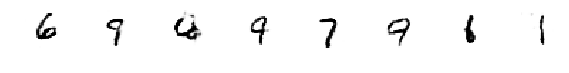

Epoch: 440
Discriminator loss: [0.6727797, 0.453125]
Generator loss: [0.8531304, 0.2109375]
(8, 1, 28, 28)


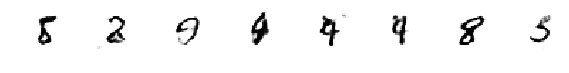

Epoch: 460
Discriminator loss: [0.64603496, 0.38671875]
Generator loss: [0.8317809, 0.2109375]
(8, 1, 28, 28)


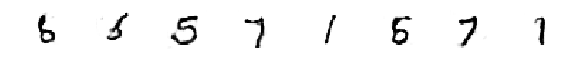

Epoch: 480
Discriminator loss: [0.6421608, 0.4296875]
Generator loss: [0.88792837, 0.1640625]
(8, 1, 28, 28)


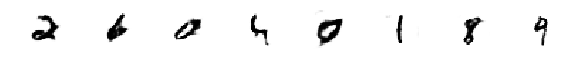

Epoch: 500
Discriminator loss: [0.6419423, 0.484375]
Generator loss: [0.80360055, 0.2421875]
(8, 1, 28, 28)


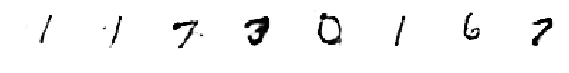

Epoch: 520
Discriminator loss: [0.6370718, 0.4375]
Generator loss: [0.94847465, 0.1015625]
(8, 1, 28, 28)


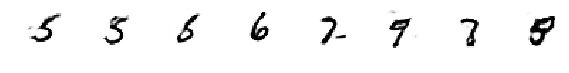

Epoch: 540
Discriminator loss: [0.6383464, 0.4296875]
Generator loss: [0.95271456, 0.0546875]
(8, 1, 28, 28)


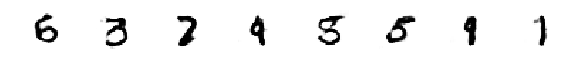

Epoch: 560
Discriminator loss: [0.68876636, 0.16796875]
Generator loss: [1.2693582, 0.0078125]
(8, 1, 28, 28)


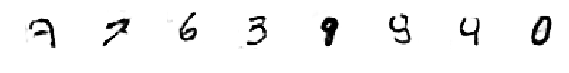

Epoch: 580
Discriminator loss: [0.6622862, 0.421875]
Generator loss: [0.90814114, 0.109375]
(8, 1, 28, 28)


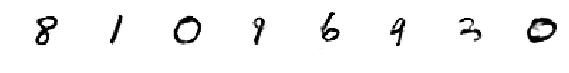

Epoch: 600
Discriminator loss: [0.6389244, 0.4296875]
Generator loss: [1.0635216, 0.046875]
(8, 1, 28, 28)


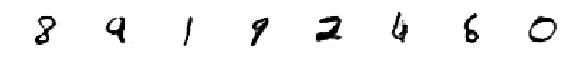

Epoch: 620
Discriminator loss: [0.65631026, 0.24609375]
Generator loss: [0.9391721, 0.1171875]
(8, 1, 28, 28)


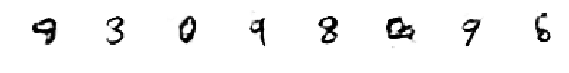

Epoch: 640
Discriminator loss: [0.70228124, 0.11328125]
Generator loss: [1.0273708, 0.0859375]
(8, 1, 28, 28)


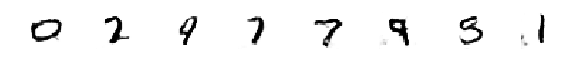

Epoch: 660
Discriminator loss: [0.6672111, 0.33203125]
Generator loss: [0.8854635, 0.1796875]
(8, 1, 28, 28)


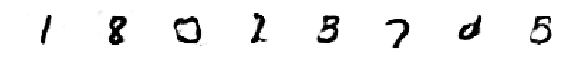

Epoch: 680
Discriminator loss: [0.6472584, 0.40625]
Generator loss: [0.92892754, 0.09375]
(8, 1, 28, 28)


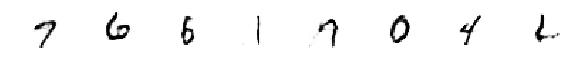

Epoch: 700
Discriminator loss: [0.64200205, 0.47265625]
Generator loss: [0.82726455, 0.25]
(8, 1, 28, 28)


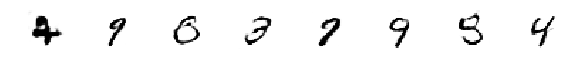

Epoch: 720
Discriminator loss: [0.64417803, 0.484375]
Generator loss: [0.74300885, 0.3828125]
(8, 1, 28, 28)


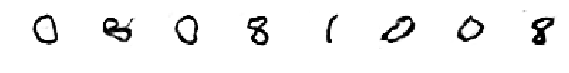

Epoch: 740
Discriminator loss: [0.6575972, 0.40234375]
Generator loss: [0.9806801, 0.0703125]
(8, 1, 28, 28)


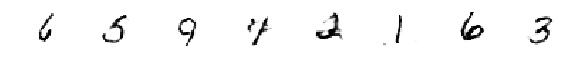

Epoch: 760
Discriminator loss: [0.64702535, 0.47265625]
Generator loss: [0.84520364, 0.2734375]
(8, 1, 28, 28)


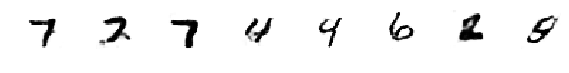

Epoch: 780
Discriminator loss: [0.63446516, 0.45703125]
Generator loss: [0.8565989, 0.1875]
(8, 1, 28, 28)


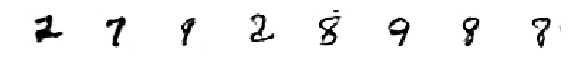

Epoch: 800
Discriminator loss: [0.6791681, 0.16015625]
Generator loss: [1.0961175, 0.03125]
(8, 1, 28, 28)


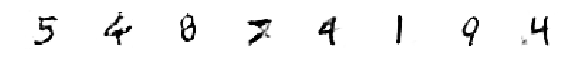

Epoch: 820
Discriminator loss: [0.6535031, 0.265625]
Generator loss: [1.1811393, 0.0390625]
(8, 1, 28, 28)


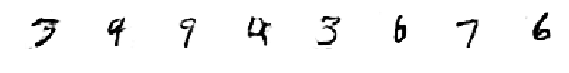

Epoch: 840
Discriminator loss: [0.66150373, 0.359375]
Generator loss: [0.8855991, 0.15625]
(8, 1, 28, 28)


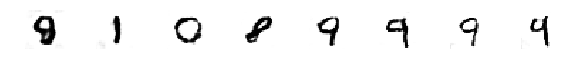

Epoch: 860
Discriminator loss: [0.6696001, 0.1953125]
Generator loss: [1.0583206, 0.0234375]
(8, 1, 28, 28)


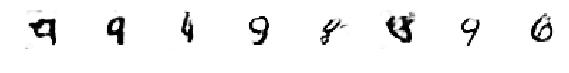

Epoch: 880
Discriminator loss: [0.67368096, 0.46484375]
Generator loss: [0.7109932, 0.5]
(8, 1, 28, 28)


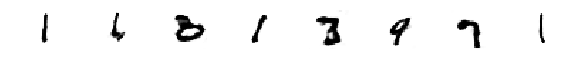

Epoch: 900
Discriminator loss: [0.67859507, 0.25390625]
Generator loss: [1.5395473, 0.0]
(8, 1, 28, 28)


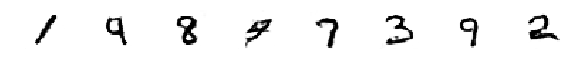

Epoch: 920
Discriminator loss: [0.6444042, 0.41015625]
Generator loss: [0.79544467, 0.3203125]
(8, 1, 28, 28)


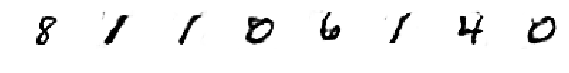

Epoch: 940
Discriminator loss: [0.7242046, 0.5]
Generator loss: [0.70090604, 0.484375]
(8, 1, 28, 28)


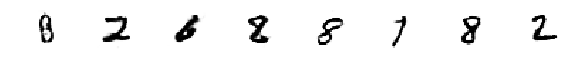

Epoch: 960
Discriminator loss: [0.64467096, 0.375]
Generator loss: [1.0409299, 0.015625]
(8, 1, 28, 28)


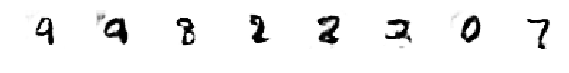

Epoch: 980
Discriminator loss: [0.63497657, 0.48046875]
Generator loss: [0.8601216, 0.234375]


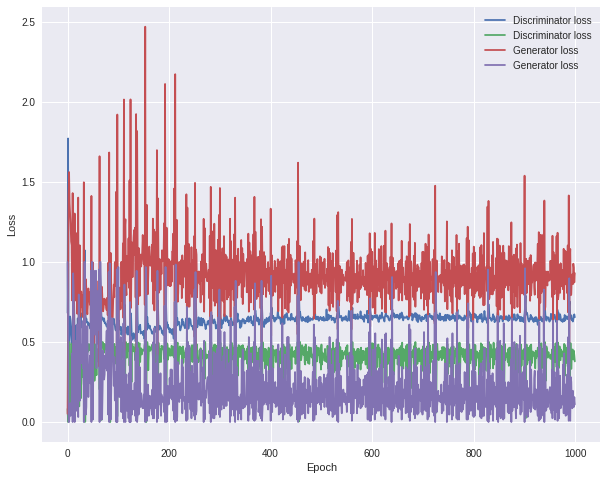

In [0]:
def main():
    # set hyper parameters    
    batch_size = 128
    epochs = 1000
    learning_rate = 0.0002
    z_input_dim = 100
    n_iter_D = 1
    n_iter_G = 5

    # run model
    model = Model(batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G)
    model.fit()


if __name__ == '__main__':
    main()

## 참고 : 모델 시각화

In [0]:
!apt-get install graphviz
!pip install -q pydot
!pip install graphviz


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3 libgraphite2-3
  libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7 libpango-1.0-0
  libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4 libpixman-1-0
  libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0 libxcb-shm0
  libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgraphite2-3 libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 28 newly installed, 0 to remove and 0 not upgraded.
Need to get 4,122 kB of archives.
After this operation, 2

Using TensorFlow backend.


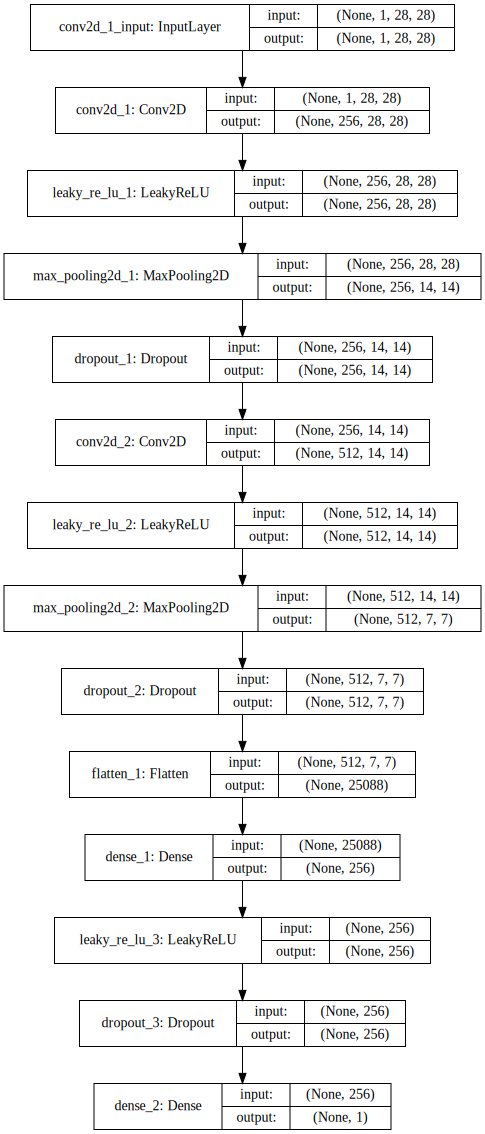

In [0]:
D = Sequential()
D.add(Conv2D(256, (5, 5),
         padding='same',
         input_shape=(1, 28, 28),
         kernel_initializer=initializers.RandomNormal(stddev=0.02)))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Conv2D(512, (5, 5), padding='same'))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Flatten())
D.add(Dense(256))
D.add(LeakyReLU(0.2))
D.add(Dropout(0.3))
D.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0002, beta_1=0.5)
D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(D, show_shapes=True).create(prog='dot', format='svg'))

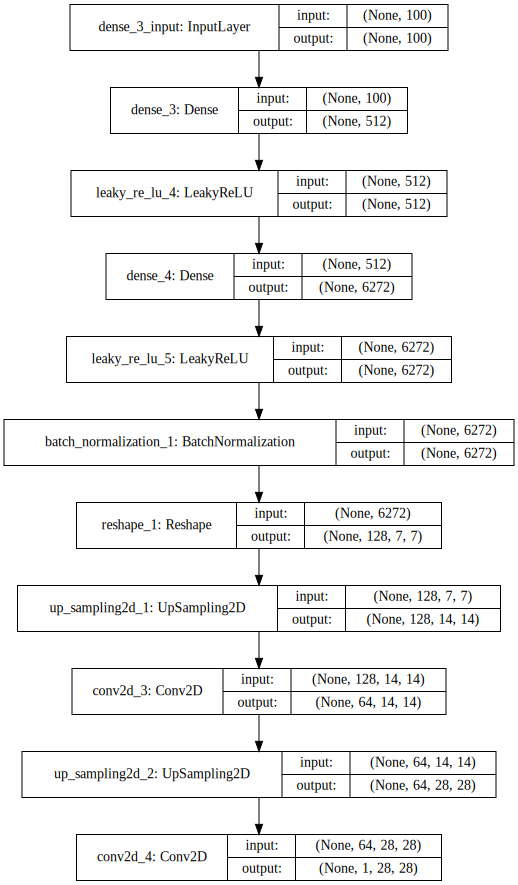

In [0]:
G = Sequential()
G.add(Dense(512, input_dim=100))
G.add(LeakyReLU(0.2))
G.add(Dense(128 * 7 * 7))
G.add(LeakyReLU(0.2))
G.add(BatchNormalization())
G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

adam = Adam(lr=0.0002, beta_1=0.5)
G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(G, show_shapes=True).create(prog='dot', format='svg'))